# HeadRest Removal of DICOM Images
### **```Author : BlackViper42```**
______

Overview
======

------
 - This notebook consists of creating HeadRest Segmentation ground truth labels of CT Scan DICOM images of head patients downloaded from `gemsvnc server-3.204.27.254` of anonymous patients. 
 
 
 - Currently this notebook predicts the segmented image of original `input_image` and this can be further taken to get `output_image` without headrest by multiplying `predicted_outcome` (binary labeled image) with `input_image`.
 
 
 - Some useful links to understand the concepts here:
    - [DICOM Processing and segmentation in python](https://www.raddq.com/dicom-processing-segmentation-visualization-in-python/)
    - [Full Preprocessing tutorial of Data-Science Bowl](https://www.kaggle.com/gzuidhof/full-preprocessing-tutorial)


Project Description
======

______

### Data
 - Input data consists of 2D dicom format images of ** 512*512 ** pixels of various patients. It is called from a directory containing all dcm format images. 
 

### DICOM Preprocessing
 - using **```pydicom```** package in python to read DICOM images.
 - Rescaling dicom images with **```Intercept```** and **```scale```** to get more cleaner image.
 

### Model Approach for creating Ground-truths
 - **```Approach_1```** - I studied on few patient data and try to fit an ellipse or static linear approach to cover head regions and setting outside values to Background value.
 - **```Approach_2```** - I tried to make optimal ellipse using normal segmentation and fit that into original image to capture head region and then setting up values to background values which are outside this ellipse.
 - **```Approach_3```** - I tried to segment original images into 2 clusters;labelling non-connected components; identifying headrest label by **```Mean```** and **```Std_dev```** of **```HU_Units```**; setting headrest label to background label
 - **```Approach_4```** - I tried to get **```max_image```** of all images and then putting this as a mask on original image and running **```Approach_3```** on it.(till now the best)
 - Labelled data was created of binary indicated **0s** and **1s** where **1s** tells presence of headrest and **0s** tells background without headrest, this is stored in npy format to be further used for ground truth formation

______
## ``` Importing Libraries```

In [41]:
import numpy as np
import dicom
import os
import matplotlib.pyplot as plt
from glob import glob
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.ndimage
from skimage import morphology
from skimage import measure
from skimage.transform import resize
from sklearn.cluster import KMeans
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.tools import FigureFactory as FF
from plotly.graph_objs import *
from matplotlib.patches import Ellipse
from skimage import io, color, measure, draw, img_as_bool
from scipy import optimize
import pandas as pd
from skimage import color

______
## ``` Importing Data :: Data Preprocessing```

> Importing Data from the given **```input_folder```**

In [42]:
data_path = "/home/ctuser/myData/s219/"
output_path = working_path = "/home/ctuser/Desktop/Semantic_Seg/data"
g = glob(data_path + "/*")

print("Total no. of CT images are: %d \nFirst 5 elements:" %len(g))
print '\n'.join(g[:5])

Total no. of CT images are: 28 
First 5 elements:
/home/ctuser/myData/s219/i7131.CTDC.7
/home/ctuser/myData/s219/i7144.CTDC.20
/home/ctuser/myData/s219/i7146.CTDC.22
/home/ctuser/myData/s219/i7151.CTDC.27
/home/ctuser/myData/s219/i7152.CTDC.28


> Loading CT Scan Images and calculate HU units for each pixels

> **```load_scan```** : loading all the image slices for each patient folder

> **```get_pixels_hu```** : Storing HU_units pixel array in **```numpy```** format for image processing


In [45]:
def load_scan(path):
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    aa=[]
    for s in os.listdir(path):
        aa.append(s)
    slices.sort(key = lambda x: int(x.InstanceNumber))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
       slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
    for s in slices:
        s.SliceThickness = slice_thickness
    return aa, slices

def get_pixels_hu(scans):
    image = np.stack([s.pixel_array for s in scans])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 1
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    #
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
    #    
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

id=17
aa, patient = load_scan(data_path)
imgs = get_pixels_hu(patient)

> Saving images in **```numpy```** format for further use

In [46]:
np.save(output_path + "fullimages_%d.npy" % (id), imgs)

> Histogram representation of **```HU_Units```**

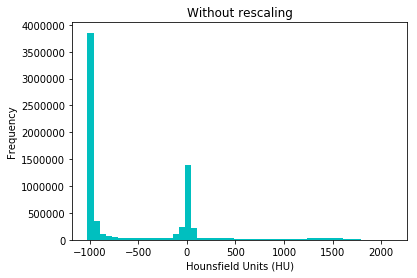

In [47]:
file_used=output_path+"fullimages_%d.npy" % id
imgs_to_process = np.load(file_used).astype(np.float64) 

plt.hist(imgs_to_process.flatten(), bins=50, color='c')
plt.title('Without rescaling')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

> checking **```Slice_Thickness```** of image slices 

In [7]:
table=[]
def load_scan(path):
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    for s in slices:
        table.append(s.SliceThickness)
    return table

In [ ]:
ag = dicom.read_file("/home/ctuser/images/input/s874")

In [189]:
ag.PixelSpacing

['0.488281', '0.488281']

> checking **```Table_Height```** of image slices 

In [164]:
table=[]
def load_scan(path):
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    for s in slices:
        table.append(s.TableHeight)
    return table

In [185]:
tablet = load_scan(data_path)

In [186]:
np.unique(tablet)

array([ 1.25,  2.5 ,  5.  ])

> Creating **```Max_Image```** from 2490 images

In [11]:
imgs = imgs+1024
imgs=imgs.astype("float32")

In [12]:
imgs_max = imgs.max(0)

In [28]:
imgs_maxxx = np.zeros_like(imgs_max,dtype='float32')
max_im = float(imgs_max.max())
imgs_maxxx = imgs_max/max_im

In [31]:
plt.imsave("Max_Image_2490",imgs_maxxx)

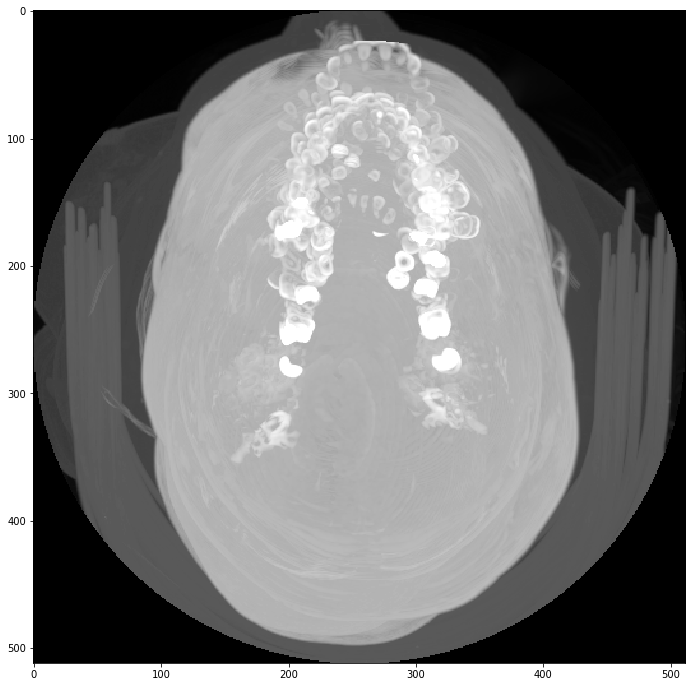

In [29]:
fig,ax = plt.subplots(1,figsize=(12,12))
ax.imshow(imgs_maxxx,cmap=plt.cm.gray)
plt.show()

> creating **```Mean_Image```** for 2490 images

In [ ]:
mean_im = np.zeros_like(imgs[0])
for i in imgs:
    mean_im += i
mean_im = np.divide(mean_im,2490)

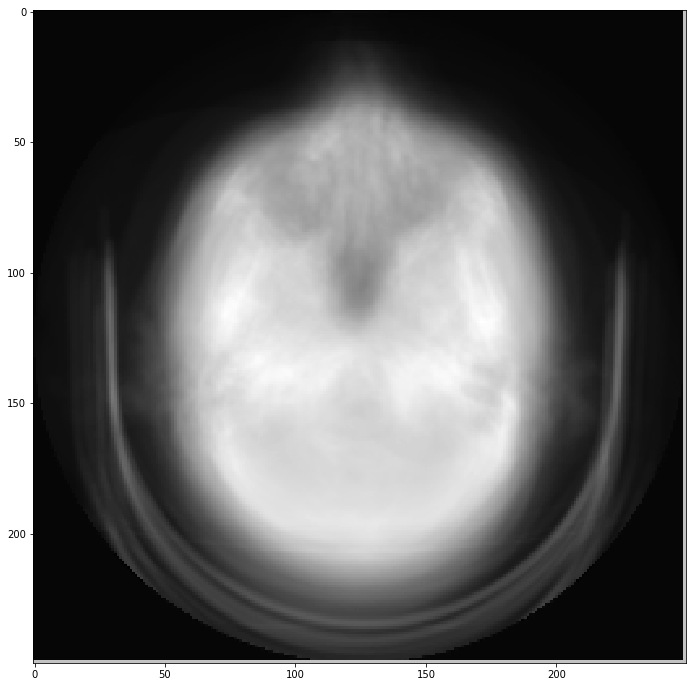

In [204]:
fig,ax = plt.subplots(1,figsize=(12,12))
ax.imshow(mean_im,cmap=plt.cm.gray)
plt.show()

In [30]:
fig.savefig("./max_image_2490.jpeg")

> Some Visualization on dataset

In [30]:
id = 1000000
imgs_to_process = np.load(output_path+'fullimages_{}.npy'.format(id))

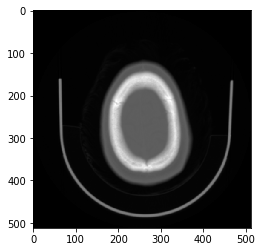

In [36]:
a = imgs[31]
fig,ax = plt.subplots(1)
ax.imshow(a,cmap=plt.cm.gray)
plt.show()

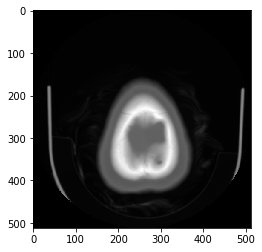

In [49]:
a = imgs[26]
fig,ax = plt.subplots(1)
ax.imshow(a,cmap=plt.cm.gray)
plt.show()

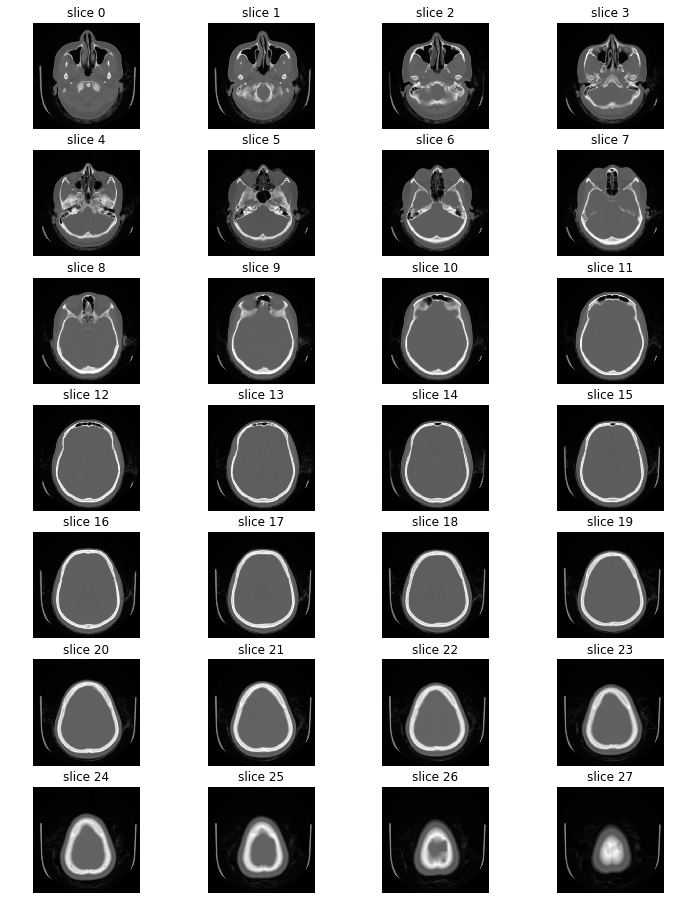

In [50]:
def sample_stack(stack, rows=7, cols=4):
    fig,ax = plt.subplots(rows,cols,figsize=[12,16])
    for i in range(rows*cols):
        ax[int(i/cols),int(i % cols)].set_title('slice %d' % i)
        ax[int(i/cols),int(i % cols)].imshow(stack[i],cmap='gray')
        ax[int(i/cols),int(i % cols)].axis('off')
    plt.show()

sample_stack(imgs)

In [ ]:
def sample_stack(stack, rows=8, cols=4):
    fig,ax = plt.subplots(rows,cols,figsize=[12,16])
    for i in range(rows*cols):
        ax[int(i/cols),int(i % cols)].set_title('slice %d' % i)
        ax[int(i/cols),int(i % cols)].imshow(stack[i],cmap='gray')
        ax[int(i/cols),int(i % cols)].axis('off')
    plt.show()

sample_stack(imgs)

In [71]:
aa

['i85755.CTDC.12',
 'i85750.CTDC.7',
 'i85753.CTDC.10',
 'i85764.CTDC.21',
 'i85757.CTDC.14',
 'i85766.CTDC.23',
 'i85769.CTDC.26',
 'i85746.CTDC.3',
 'i85774.CTDC.31',
 'i85751.CTDC.8',
 'i85744.CTDC.1',
 'i85771.CTDC.28',
 'i85765.CTDC.22',
 'i85772.CTDC.29',
 'i85756.CTDC.13',
 'i85758.CTDC.15',
 'i85770.CTDC.27',
 'i85763.CTDC.20',
 'i85768.CTDC.25',
 'i85762.CTDC.19',
 'i85745.CTDC.2',
 'i85760.CTDC.17',
 'i85775.CTDC.32',
 'i85767.CTDC.24',
 'i85761.CTDC.18',
 'i85747.CTDC.4',
 'i85748.CTDC.5',
 'i85749.CTDC.6',
 'i85759.CTDC.16',
 'i85754.CTDC.11',
 'i85773.CTDC.30',
 'i85752.CTDC.9']

> A **```Static Elliptic filter```** to remove headrest

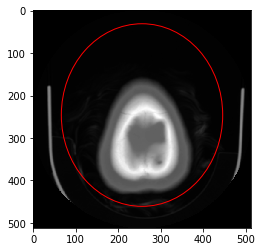

In [51]:
fig,ax = plt.subplots(1)
ax.imshow(a,cmap=plt.cm.gray)
ellipse = Ellipse(xy=(256,246), width=380, height=430, edgecolor='r',fill=False, lw=1)
ax.add_patch(ellipse)
plt.show()

In [39]:
def filter_ellipse(imgs_array):
    for a in imgs_array:
        o,p=256,246
        arr_x,arr_y=512.0,512.0
        y,x = np.ogrid[0.0:512.0,0.0:512.0]
        mask = ((x-256.0)*(x-256.0))/(190.0*190.0) + ((y-246.0)*(y-246.0))/(215.0*215.0) > 1.0
        a[mask] = -1000
    return(imgs_array,mask)
    
ad = filter_ellipse(imgs_to_process)

> A **```Linear Elliptic filter```** to remove headrest

In [ ]:
def filter_linear(imgs_array):
    for a in imgs_array:
        for j in range(100,450):
            for i in range(400,512):
                c=np.mean(np.array(a[j,i-20:i]))
                if c<=-999:
                    a[j,i:512]=-1000
        for j in range(100,450):
            for i in range(0,100):
                c=np.mean(np.array(a[j,i:i+20]))
                if c<=-999:
                    a[j,0:i]=-1000
            
        for i in range(0,512):
            for j in range(450,512):
                c = np.mean(np.array(a[j:j+20,i]))
                if c<=-999:
                    a[j:512,i]=-1000
                else:
                    d = np.mean(np.array(a[j-20:j,i]))
                    if d<=-999:
                        a[j:512,i]=-1000
    return(imgs_array)
imgs_to_process_1inear_filter = filter_linear(imgs_to_process)

In [ ]:
def sample_stack(stack, rows=8, cols=4):
    fig,ax = plt.subplots(rows,cols,figsize=[12,16])
    for i in range(rows*cols):
        ax[int(i/cols),int(i % cols)].set_title('slice %d' % i)
        ax[int(i/cols),int(i % cols)].imshow(stack[i],cmap='gray')
        ax[int(i/cols),int(i % cols)].axis('off')
        ellipse = Ellipse(xy=(256,246), width=380, height=430, edgecolor='r',fill=False, lw=1)
        ax[int(i/cols),int(i % cols)].add_patch(ellipse)
    plt.show()

sample_stack(imgs_to_process)

In [15]:
a = imgs_to_process[4]

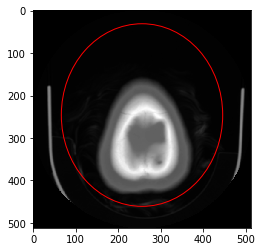

In [52]:
fig,ax = plt.subplots(1)
ax.imshow(a,cmap=plt.cm.gray)
ellipse = Ellipse(xy=(256,246), width=380, height=430, edgecolor='r',fill=False, lw=1)
ax.add_patch(ellipse)
plt.show()

> **```Optimal Ellipse fitting ```** using matplotlib by segmentation using normal threshold

In [53]:
a=imgs_to_process[0]

Optimization terminated successfully.
         Current function value: -305.000000
         Iterations: 19
         Function evaluations: 113


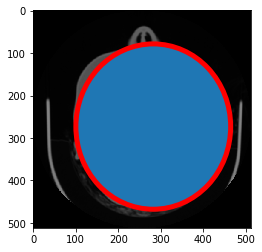

In [54]:
image = np.int16(a)
regions = measure.regionprops(label_image=image)
bubble = regions[0]

r, c = bubble.centroid
r_radius = bubble.major_axis_length / 2.
c_radius = bubble.minor_axis_length / 2.

def cost(params):
    r,c,r_radius,c_radius = params
    coords = draw.ellipse(r, c, r_radius,c_radius, shape=image.shape)
    template = np.zeros_like(image)
    template[coords] = 0
    return -np.sum(template == image)

r,c,r_radius,c_radius = optimize.fmin(cost, (r,c,r_radius,c_radius))

import matplotlib.pyplot as plt

f, ax = plt.subplots()
ellipse = Ellipse(xy=(r,c), width=2*c_radius, height=2*r_radius,fill=True,lw=5,edgecolor='r')
ax.imshow(image, cmap='gray', interpolation='nearest')
ax.add_artist(ellipse)
plt.show()

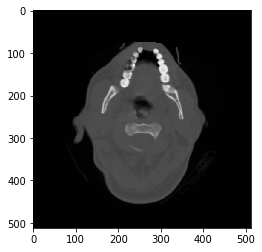

In [23]:
fig,ax = plt.subplots(1)
ax.imshow(a,cmap=plt.cm.gray)
plt.show()

Optimization terminated successfully.
         Current function value: -673.000000
         Iterations: 22
         Function evaluations: 95


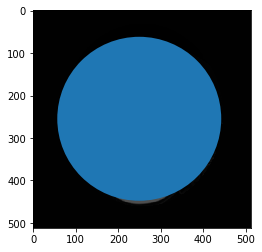

In [24]:
image = a
regions = measure.regionprops(image)
bubble = regions[0]

y0, x0 = bubble.centroid
r = bubble.major_axis_length / 2.

def cost(params):
    x0, y0, r = params
    coords = draw.circle(y0, x0, r, shape=image.shape)
    template = np.zeros_like(image)
    template[coords] = 1
    return -np.sum(template == image)

x0, y0, r = optimize.fmin(cost, (x0, y0, r))

import matplotlib.pyplot as plt

f, ax = plt.subplots()
circle = plt.Circle((x0, y0), r)
ax.imshow(image, cmap='gray', interpolation='nearest')
ax.add_artist(circle)
plt.show()

In [55]:
id = 1000000
imgs_to_process = np.load(output_path+'fullimages_{}.npy'.format(id))

In [9]:
def distance(x,y):
    dist = np.sqrt((x-256.)*(x-256.) + (y-256.)*(y-256.))
    return dist
def min_distance(df):
    lst = np.array(df['HU_Value'])
    aggg=0
    bggg=0
    ccc=[]
    lst = sorted(lst)
    index=-1
    distance = max(lst)-min(lst)
    for i in range(len(lst)-1):
        if lst[i+1] - lst[i] < distance:
            distance = lst[i+1] - lst[i] 
            index = i
    for i in range(len(lst)-1):
        if lst[i+1] - lst[i] == distance:
            id_1 = lst[i]
            id_2 = lst[i+1]
            if lst[i]==lst[i+1]:
                aggg = np.array(df['label'][df['HU_Value']==lst[i]])
                bggg = aggg[1]
                aggg = aggg[0]
            else:
                aggg = df['label'][df['HU_Value']==lst[i]]
                bggg = df['label'][df['HU_Value']==lst[i+1]]
    return  aggg,bggg,distance

In [10]:
def find_headrest_label(std_table,mean_table,labels):
    labels_vals = np.unique(labels)
    #print("iteration 0 initiated:\n")
    throw_label=[]
    e1 =pd.DataFrame(mean_table[(mean_table['HU_Value']>=-100) & (mean_table['HU_Value']<400)])
    e3 =pd.DataFrame(mean_table[(mean_table['HU_Value']>=120) & (mean_table['HU_Value']<400)])
    #print(e3)
    connected_headrest_label_1 = np.array(e3['label'].values)
    #print(connected_headrest_label_1)
    #print("length of connected_headrest_label_1 " ,len(connected_headrest_label_1))
    sel_label=e1['label'].values
    e2 =pd.DataFrame(std_table[std_table['label'].isin(sel_label)])
    #print(e2)
    e4 =pd.DataFrame(std_table[(std_table['HU_Value']>150) & (std_table['HU_Value']<300)])
    #print(e4)
    connected_headrest_label_2 = np.array(e4['label'].values)
    #print(connected_headrest_label_2)
    #print("Iteration 1 initiated:\n")
    y=0
    while(y==0):
        if np.array(e2['HU_Value']).size == 1:
            break
        t1,t2,filt = min_distance(e2)
        #print(t1)
        #print(t2)
        t1 = np.int(t1)
        t2 = np.int(t2)
        if filt<=50:
            throw_label.append(t1)
            throw_label.append(t2)
            e2 = e2[~e2['label']==t1]
        else:
            y=y+1
        if np.array(e2['HU_Value']).size == 1:
            break
        if np.array(e2['HU_Value']).size == 0:
            break
    print('--------------------------------------------\n')
    if len(throw_label)==0:
        if len(connected_headrest_label_1)==1:
            #print("-----------------aaaaaaaaaaalllllllllll---------------")
            throw_label.append(np.int(connected_headrest_label_1))
        else:
            b3 = np.array([val for val in connected_headrest_label_1 if val in connected_headrest_label_2])
            #print("-------------bjfbej-------------")
            print(b3)
            if len(b3)!=0:
                throw_label.append(np.int(b3))
    return(throw_label)

def remove_headrest(img, display=False):
    img_2 = img
    row_size= img.shape[0]
    col_size = img.shape[1]
    
    mean = np.mean(img)
    std = np.std(img)
    img = img-mean
    img = img/std
    # Find the average pixel value near the lungs
    # to renormalize washed out images
    #middle = img[int(col_size/5):int(col_size/5*4),int(row_size/5):int(row_size/5*4)] 
    #mean = np.mean(middle)  
    #max = np.max(img)
    #min = np.min(img)
    # To improve threshold finding, I'm moving the 
    # underflow and overflow on the pixel spectrum
    #img[img==max]=mean
    #img[img==min]=mean
    
    # Using Kmeans to separate foreground (soft tissue / bone) and background (lung/air)
    
    kmeans = KMeans(n_clusters=2).fit(np.reshape(img,[np.prod(img.shape),1]))
    centers = sorted(kmeans.cluster_centers_.flatten())
    threshold = np.mean(centers)
    thresh_img = np.where(img<threshold,0,1)  # threshold the image

    # First erode away the finer elements, then dilate to include some of the pixels surrounding the lung.  
    # We don't want to accidentally clip the lung.
    #eroded = morphology.erosion(thresh_img,np.ones([3,3]))
    #dilation = morphology.dilation(thresh_img,np.ones([1,1]))

    labels = measure.label(thresh_img,neighbors=8,connectivity=2)
    region = measure.regionprops(labels,img_2)
    
    
    label_vals = np.unique(labels)
    #print(label_vals)
    smallest_distance=100000000000000
    head_label=0
    for lab in np.unique(labels):
        cent_x,cent_y = region[lab-1].centroid
        dist = distance(cent_x,cent_y)
        if smallest_distance>dist:
            smallest_distance=dist
            head_label = lab
    ## we got the head label.
    #print('\n -------------------------------------------')
    labels_flat = labels.reshape(np.prod(labels.shape),1)
    labels_flat = pd.DataFrame(labels_flat)
    labels_flat.columns=['label']

    img_2_flat = np.array(np.reshape(img_2,[np.prod(img_2.shape),1]))
    img_2_flat = pd.DataFrame(img_2_flat)
    img_2_flat.columns = ['HU_Value']

    df=pd.DataFrame.join(labels_flat,img_2_flat)

    std = pd.DataFrame(df.groupby('label').std())
    std = std[np.isfinite(std['HU_Value'])]

    std = pd.DataFrame(std,dtype="int")
    std.reset_index(level=0, inplace=True)
    std_input = std[std['label']!=head_label]
    mea = pd.DataFrame(df.groupby('label').mean(),dtype='int')
    mea.reset_index(level=0, inplace=True)
    mea_input = mea[mea['label']!=head_label]
    #print("Std Table: ")
    #print std_input
    #print head_label,"gfeyufgefueheiuf"
    #print std
    #print("Mean Table: ")
    #print mea_input
    throw_label = find_headrest_label(labels=labels,mean_table=mea_input,std_table=std_input)
    
    if len(throw_label)==0:
        print("Raised an error: Your algorithm can not successfully filter the labels")
        return(0)
    
    #labels[labels==0]=head_label
    for lab in throw_label:
        labels[labels==lab]=0
    mask = np.ndarray([row_size,col_size],dtype=np.int8)
    mask[:] = 1
    mask[labels==0]= 0
    #for N in labels:
    #    mask = mask + np.where(labels==N,1,0)
    #print(np.unique(mask))
    mask = morphology.dilation(mask,np.ones([15,15])) # one last dilation

    if (display):
        fig, ax = plt.subplots(3,2, figsize=[12, 12])
        ax[0,0].set_title("Original")
        ax[0,0].imshow(img, cmap='gray')
        ax[0,0].axis('off')
        ax[0, 1].set_title("Threshold")
        ax[0, 1].imshow(thresh_img, cmap='gray')
        ax[0, 1].axis('off')
        ax[1, 0].set_title("After Erosion and Dilation")
        ax[1, 0].imshow(thresh_img, cmap='gray')
        ax[1, 0].axis('off')
        ax[1, 1].set_title("Color Labels")
        ax[1, 1].imshow(labels)
        ax[1, 1].axis('off')
        ax[2, 0].set_title("Final Mask")
        ax[2, 0].imshow(mask, cmap='gray')
        ax[2, 0].axis('off')
        ax[2, 1].set_title("Apply Mask on Original")
        ax[2,1].imshow(mask*img, cmap='gray')
        ax[2,1].axis('off')
       
        plt.show()
    return (0)

In [ ]:
#img = imgs_to_process[23]
i=0
for img in imgs_to_process[1:3]:
    print("slice %d :" %i)
    dilated = remove_headrest(img, display=True)
    i+=1

> Importing **```Max_Image```** mask for creating **```ground_truth```**

In [10]:
id = 1000000
imgs_to_process = np.load(output_path+'fullimages_{}.npy'.format(id))

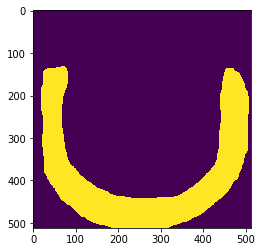

In [55]:
mas = plt.imread("/home/ctuser/Desktop/Image_Seg/Mask_Image_2490.jpg")
mas = mas[:,:,0:3]
img = color.rgb2gray(mas)
mask_head = np.ones_like(img)
mask_head[img==1.]=0
plt.imshow(mask_head)
plt.show()

In [57]:
def distance(x,y):
    dist = np.sqrt((x-256.)*(x-256.) + (y-256.)*(y-256.))
    return dist
def min_distance(df):
    lst = np.array(df['HU_Value'])
    aggg=0
    bggg=0
    ccc=[]
    lst = sorted(lst)
    index=-1
    distance = max(lst)-min(lst)
    for i in range(len(lst)-1):
        if lst[i+1] - lst[i] < distance:
            distance = lst[i+1] - lst[i] 
            index = i
    for i in range(len(lst)-1):
        if lst[i+1] - lst[i] == distance:
            id_1 = lst[i]
            id_2 = lst[i+1]
            if lst[i]==lst[i+1]:
                aggg = np.array(df['label'][df['HU_Value']==lst[i]])
                bggg = aggg[1]
                aggg = aggg[0]
            else:
                aggg = df['label'][df['HU_Value']==lst[i]]
                bggg = df['label'][df['HU_Value']==lst[i+1]]
    return  aggg,bggg,distance

def find_headrest_label(std_table,mean_table,labels):
    labels_vals = np.unique(labels)
    #print("iteration 0 initiated:\n")
    throw_label=[]
    e1 =pd.DataFrame(mean_table[(mean_table['HU_Value']>=-50) & (mean_table['HU_Value']<400)])
    e3 =pd.DataFrame(mean_table[(mean_table['HU_Value']>=10) & (mean_table['HU_Value']<800)])
    #print(e3)
    connected_headrest_label_1 = np.array(e3['label'].values)
    #print(connected_headrest_label_1)
    #print("length of connected_headrest_label_1 " ,len(connected_headrest_label_1))
    sel_label=e1['label'].values
    e2 =pd.DataFrame(std_table[std_table['label'].isin(sel_label)])
    #print(e2)
    e4 =pd.DataFrame(std_table[(std_table['HU_Value']>150) & (std_table['HU_Value']<300)])
    #print(e4)
    connected_headrest_label_2 = np.array(e4['label'].values)
    #print(connected_headrest_label_2)
    #print("Iteration 1 initiated:\n")
    y=0
    while(y==0):
        if np.array(e2['HU_Value']).size == 0:
            break
        if np.array(e2['HU_Value']).size == 1:
            break
        t1,t2,filt = min_distance(e2)
        #print(t1)
        #print(t2)
        t1 = np.int(t1)
        t2 = np.int(t2)
        if filt<=50:
            throw_label.append(t1)
            throw_label.append(t2)
            e2 = e2[~e2['label']==t1]
        else:
            y=y+1
        if np.array(e2['HU_Value']).size == 1:
            break
        if np.array(e2['HU_Value']).size == 0:
            break
    print('--------------------------------------------\n')
    if len(throw_label)==0:
        if len(connected_headrest_label_1)==1:
            #print("-----------------aaaaaaaaaaalllllllllll---------------")
            throw_label.append(np.int(connected_headrest_label_1))
        else:
            b3 = np.array([val for val in connected_headrest_label_1 if val in connected_headrest_label_2])
            #print("-------------bjfbej-------------")
            print(b3)
            if len(b3)!=0:
                throw_label.append(np.int(b3))
    return(throw_label)

def remove_headrest(img, display=False):
    img_2 = img
    row_size= img.shape[0]
    col_size = img.shape[1]
    
    mean = np.mean(img)
    std = np.std(img)
    img = img-mean
    img = img/std
    # Find the average pixel value near the lungs
    # to renormalize washed out images
    #middle = img[int(col_size/5):int(col_size/5*4),int(row_size/5):int(row_size/5*4)] 
    #mean = np.mean(middle)  
    #max = np.max(img)
    #min = np.min(img)
    # To improve threshold finding, I'm moving the 
    # underflow and overflow on the pixel spectrum
    #img[img==max]=mean
    #img[img==min]=mean
    
    # Using Kmeans to separate foreground (soft tissue / bone) and background (lung/air)
    
    kmeans = KMeans(n_clusters=2).fit(np.reshape(img,[np.prod(img.shape),1]))
    centers = sorted(kmeans.cluster_centers_.flatten())
    threshold = np.mean(centers)
    thresh_img = np.where(img<threshold,0,1)  # threshold the image

    # First erode away the finer elements, then dilate to include some of the pixels surrounding the lung.  
    # We don't want to accidentally clip the lung.
    #eroded = morphology.erosion(thresh_img,np.ones([3,3]))
    #dilation = morphology.dilation(thresh_img,np.ones([1,1]))

    labels = measure.label(thresh_img,neighbors=8,connectivity=2)
    region = measure.regionprops(labels,img_2)
    
    
    label_vals = np.unique(labels)
    #print(label_vals)
    smallest_distance=100000000000000
    head_label=0
    for lab in np.unique(labels):
        cent_x,cent_y = region[lab-1].centroid
        dist = distance(cent_x,cent_y)
        if smallest_distance>dist:
            smallest_distance=dist
            head_label = lab
    ## we got the head label.
    #print('\n -------------------------------------------')
    labels_flat = labels.reshape(np.prod(labels.shape),1)
    labels_flat = pd.DataFrame(labels_flat)
    labels_flat.columns=['label']

    img_2_flat = np.array(np.reshape(img_2,[np.prod(img_2.shape),1]))
    img_2_flat = pd.DataFrame(img_2_flat)
    img_2_flat.columns = ['HU_Value']

    df=pd.DataFrame.join(labels_flat,img_2_flat)

    std = pd.DataFrame(df.groupby('label').std())
    std = std[np.isfinite(std['HU_Value'])]

    std = pd.DataFrame(std,dtype="int")
    std.reset_index(level=0, inplace=True)
    std_input = std[std['label']!=head_label]
    mea = pd.DataFrame(df.groupby('label').mean(),dtype='int')
    mea.reset_index(level=0, inplace=True)
    mea_input = mea[mea['label']!=head_label]
    print("Std Table: ")
    print std_input
    print head_label,"gfeyufgefueheiuf"
    print std
    print("Mean Table: ")
    print mea_input
    throw_label = find_headrest_label(labels=labels,mean_table=mea_input,std_table=std_input)
    mask = np.ndarray([row_size,col_size],dtype=np.int8)
    mask[:] = 1
    if len(throw_label)==0:
        print("Raised an error: Your algorithm can not successfully filter the labels")
    #print head_label
    #labels[labels==0]=head_label
    else:
        for lab in throw_label:
            labels[labels==lab]=0
        mask[labels==0]= 0
    #for N in labels:
    #    mask = mask + np.where(labels==N,1,0)
    #print(np.unique(mask))
        mask = morphology.dilation(mask,np.ones([10,10])) # one last dilation

    if (display):
        fig, ax = plt.subplots(3,2, figsize=[12, 12])
        ax[0, 0].set_title("Original")
        ax[0, 0].imshow(img, cmap='gray')
        ax[0, 0].axis('off')
        ax[0, 1].set_title("Threshold")
        ax[0, 1].imshow(thresh_img, cmap='gray')
        ax[0, 1].axis('off')
        ax[1, 0].set_title("After Erosion and Dilation")
        ax[1, 0].imshow(thresh_img, cmap='gray')
        ax[1, 0].axis('off')
        ax[1, 1].set_title("Color Labels")
        ax[1, 1].imshow(labels)
        ax[1, 1].axis('off')
        ax[2, 0].set_title("Final Mask")
        ax[2, 0].imshow(mask, cmap='gray')
        ax[2, 0].axis('off')
        ax[2, 1].set_title("Apply Mask on Original")
        ax[2, 1].imshow(mask*img, cmap='gray')
        ax[2, 1].axis('off')
       
        plt.show()
    return (0)

In [66]:
def headrest_segmented_filter(img, display=False):
    img_2 = img
    img_2 = img_2*mask_head
    img_3 = img*mask_head
    row_size= img.shape[0]
    col_size = img.shape[1]
    
    mean = np.mean(img)
    std = np.std(img)
    img = img-mean
    img = img/std
    # Find the average pixel value near the lungs
    # to renormalize washed out images
    #middle = img[int(col_size/5):int(col_size/5*4),int(row_size/5):int(row_size/5*4)] 
    #mean = np.mean(middle)  
    #max = np.max(img)
    #min = np.min(img)
    # To improve threshold finding, I'm moving the 
    # underflow and overflow on the pixel spectrum
    #img[img==max]=mean
    #img[img==min]=mean
    
    # Using Kmeans to separate foreground (soft tissue / bone) and background (lung/air)
    
    kmeans = KMeans(n_clusters=2).fit(np.reshape(img,[np.prod(img.shape),1]))
    centers = sorted(kmeans.cluster_centers_.flatten())
    threshold = np.mean(centers)
    thresh_img = np.where(img<threshold,0,1)  # threshold the image

    # First erode away the finer elements, then dilate to include some of the pixels surrounding the lung.  
    # We don't want to accidentally clip the lung.
    #eroded = morphology.erosion(thresh_img,np.ones([3,3]))
    dilation = morphology.dilation(thresh_img,np.ones([1,1]))

    labels = measure.label(dilation,neighbors=8,connectivity=2)
    segment_labels = np.copy(labels)
    region = measure.regionprops(labels,img_2)
    
    
    label_vals = np.unique(labels)
    #print(label_vals)
    smallest_distance=100000000000000
    head_label=0
    for lab in np.unique(labels):
        cent_x,cent_y = region[lab-1].centroid
        dist = distance(cent_x,cent_y)
        if smallest_distance>dist:
            smallest_distance=dist
            head_label = lab
    ## we got the head label.
    #print('\n -------------------------------------------')
    labels_flat = labels.reshape(np.prod(labels.shape),1)
    labels_flat = pd.DataFrame(labels_flat)
    labels_flat.columns=['label']

    img_2_flat = np.array(np.reshape(img_2,[np.prod(img_2.shape),1]))
    img_2_flat = pd.DataFrame(img_2_flat)
    img_2_flat.columns = ['HU_Value']

    df=pd.DataFrame.join(labels_flat,img_2_flat)

    std = pd.DataFrame(df.groupby('label').std())
    std = std[np.isfinite(std['HU_Value'])]

    std = pd.DataFrame(std,dtype="int")
    std.reset_index(level=0, inplace=True)
    std_input = std[std['label']!=head_label]
    std_input = std_input[std_input['HU_Value']!=0.]
    mea = pd.DataFrame(df.groupby('label').mean(),dtype='int')
    mea.reset_index(level=0, inplace=True)
    mea_input = mea[mea['label']!=head_label]
    mea_input = mea_input[mea_input['HU_Value']!=0.]
    #print("Std Table: ")
    #print std_input
    #print head_label,"gfeyufgefueheiuf"
    #print std
    #print("Mean Table: ")
    #print mea_input
    throw_label = find_headrest_label(labels=labels,mean_table=mea_input,std_table=std_input)
    mask = np.ndarray([row_size,col_size],dtype=np.int8)
    labels[labels==head_label]=0
    keep_label =[i for i in label_vals if i not in throw_label]
    #print keep_label
    for lab in keep_label:
        labels[labels==lab]=0
    mask[:] = 0
    #print throw_label
    if len(throw_label)==0:
        print("Raised an error: Your algorithm can not successfully filter the labels")
    else:
        for lab in throw_label:
            labels[labels==lab]=1
        mask[labels==1]= 1
    #for N in labels:
    #    mask = mask + np.where(labels==N,1,0)
    #print(np.unique(mask))
        mask = morphology.dilation(mask,np.ones([10,10])) # one last dilation

    if (display):
        fig, ax = plt.subplots(2,2, figsize=[12, 12])
        ax[0, 0].set_title("Original")
        ax[0, 0].imshow(img, cmap='gray')
        ax[0, 0].axis('off')
        ax[0, 1].set_title("with mask")
        ax[0, 1].imshow(img_2, cmap='gray')
        ax[0, 1].axis('off')
        #ax[1, 0].set_title("After Erosion and Dilation")
        #ax[1, 0].imshow(thresh_img, cmap='gray')
        #ax[1, 0].axis('off')
        ax[1, 0].set_title("Threshold")
        ax[1, 0].imshow(thresh_img, cmap='gray')
        ax[1, 0].axis('off')
        ax[1, 1].set_title("Headrest label")
        ax[1, 1].imshow(labels)
        ax[1, 1].axis('off')
        #ax[2, 1].set_title("Apply Mask on Original")
        #ax[2, 1].imshow(mask*img, cmap='gray')
        #ax[2, 1].axis('off')
       
        plt.show()
    return labels

--------------------------------------------



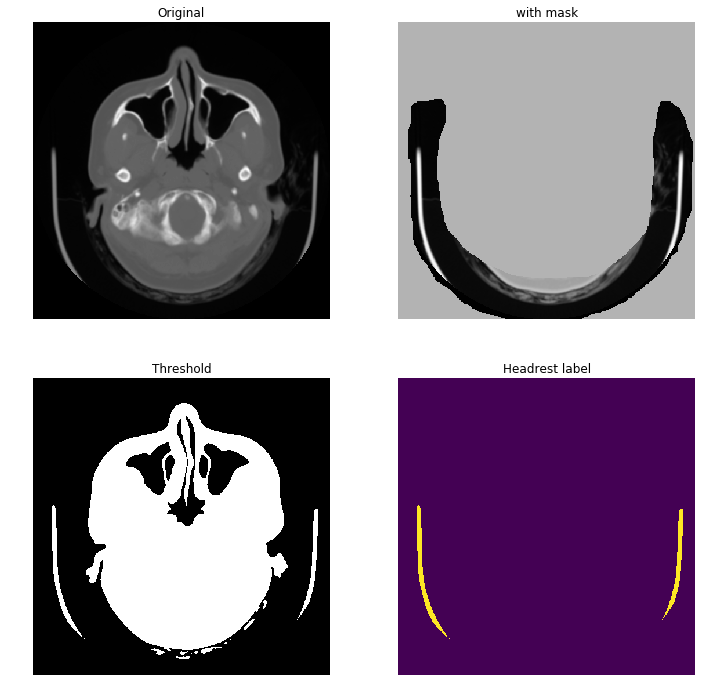

In [68]:
img = imgs_to_process[1]
#i=0
#for img in imgs_to_process:
#    print("slice %d :" %i)
headrest_label = headrest_segmented_filter(img, display=True)
#    i+=1

slice 0 :
--------------------------------------------



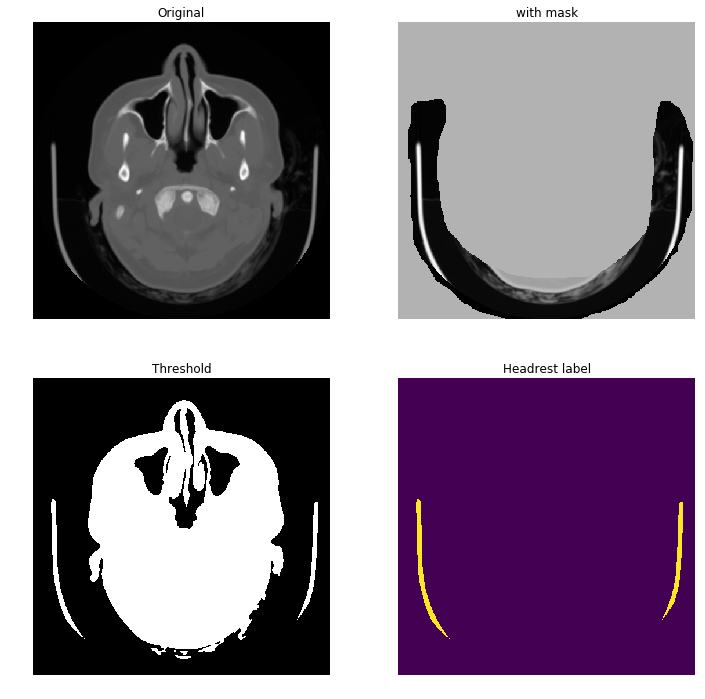

slice 1 :
--------------------------------------------



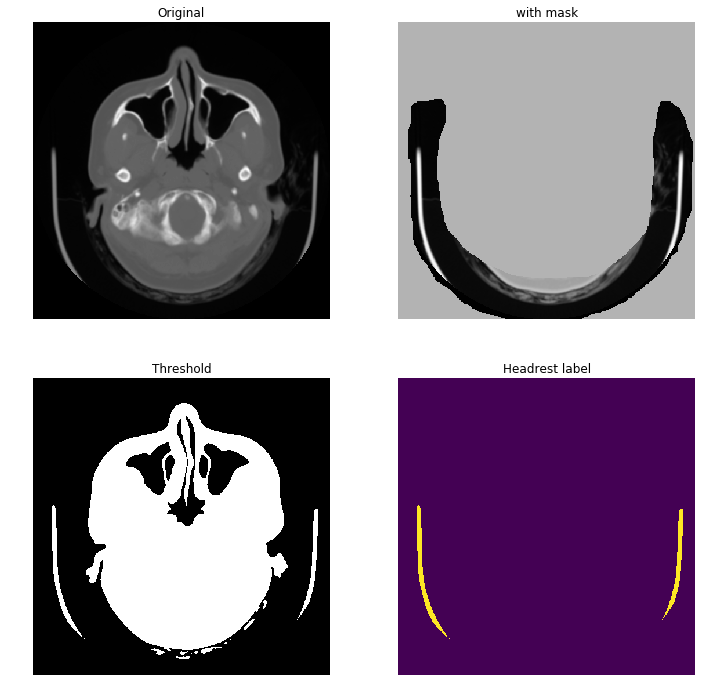

slice 2 :
--------------------------------------------



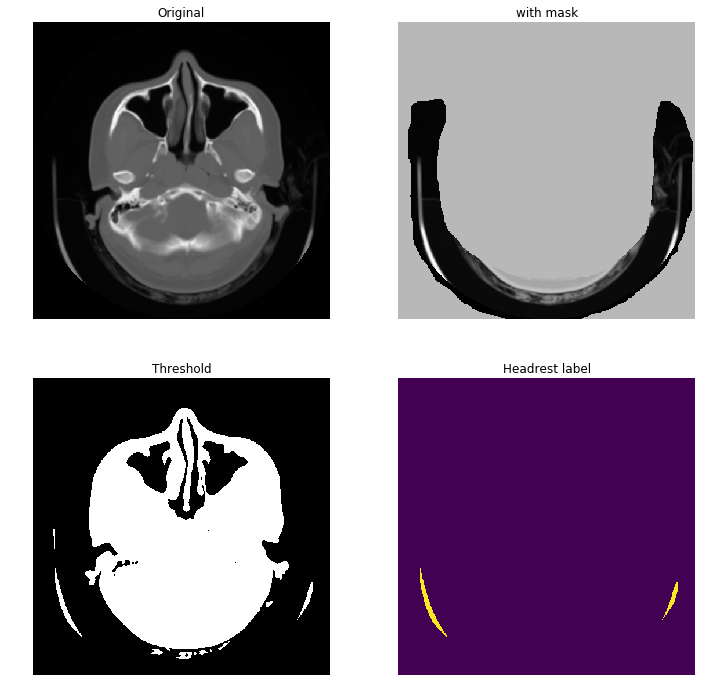

slice 3 :
--------------------------------------------



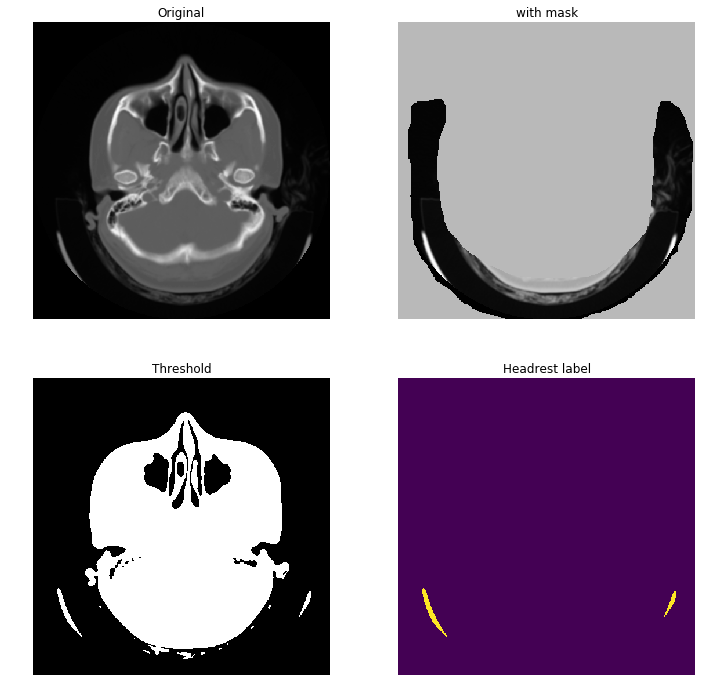

slice 4 :
--------------------------------------------



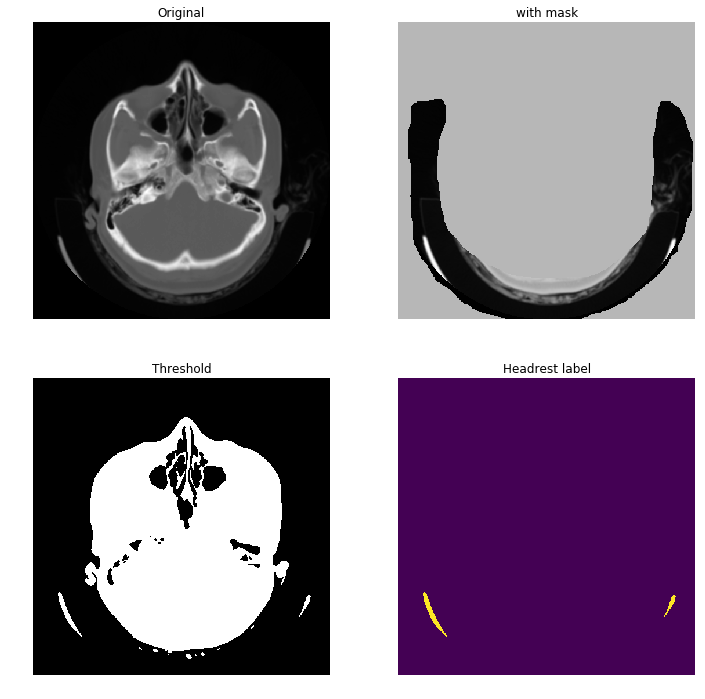

slice 5 :
--------------------------------------------



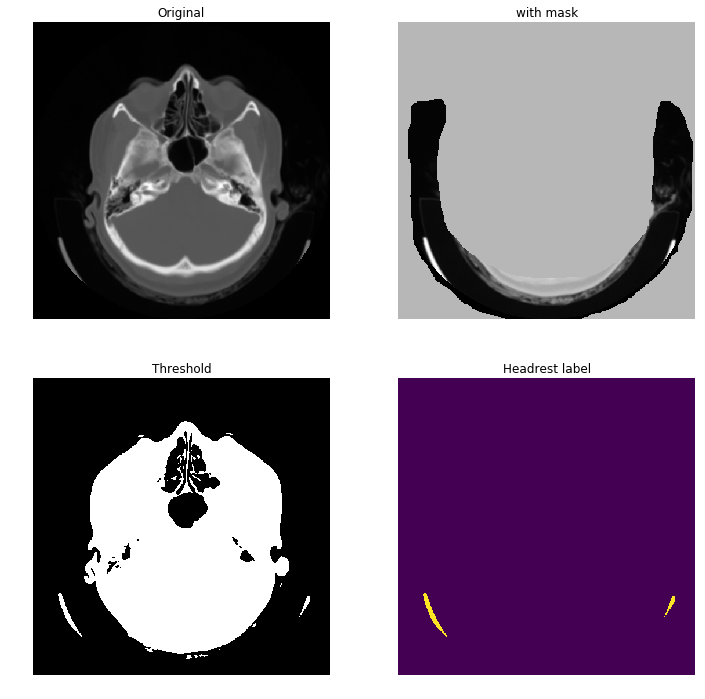

slice 6 :
--------------------------------------------



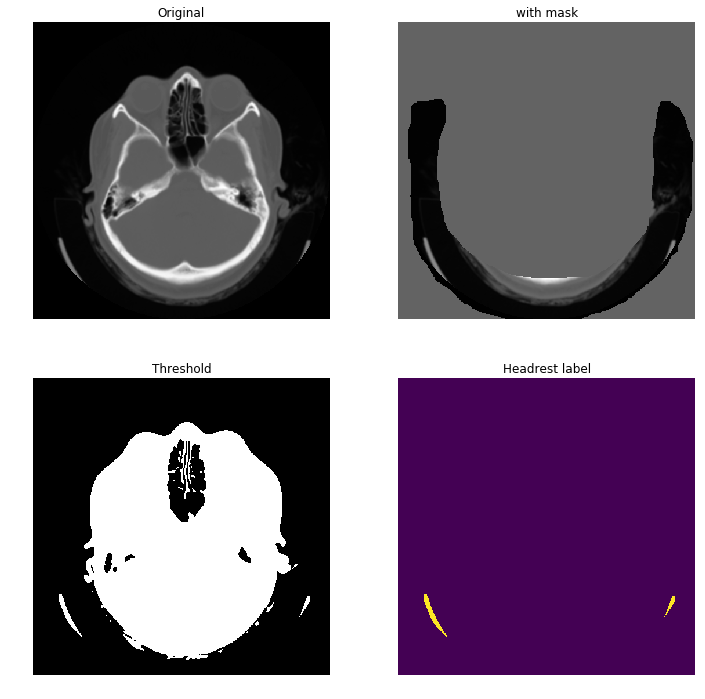

slice 7 :
--------------------------------------------



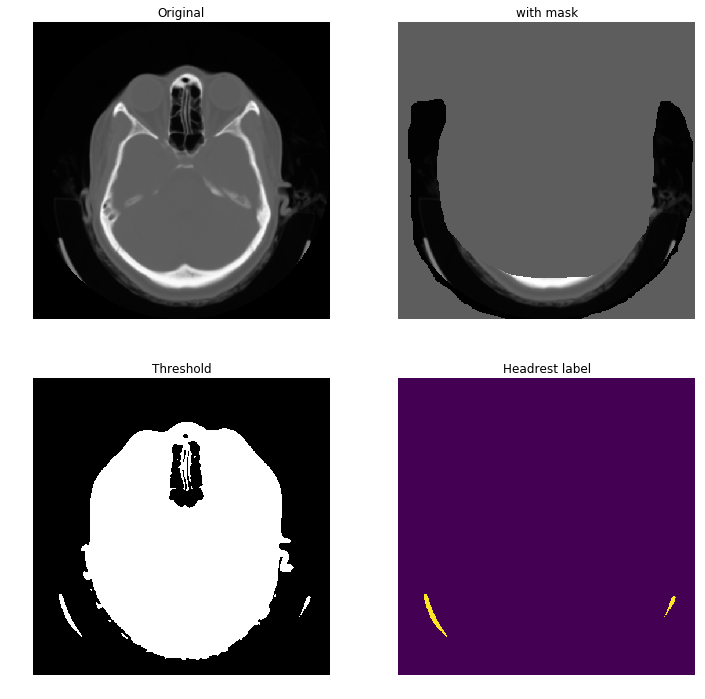

slice 8 :
--------------------------------------------



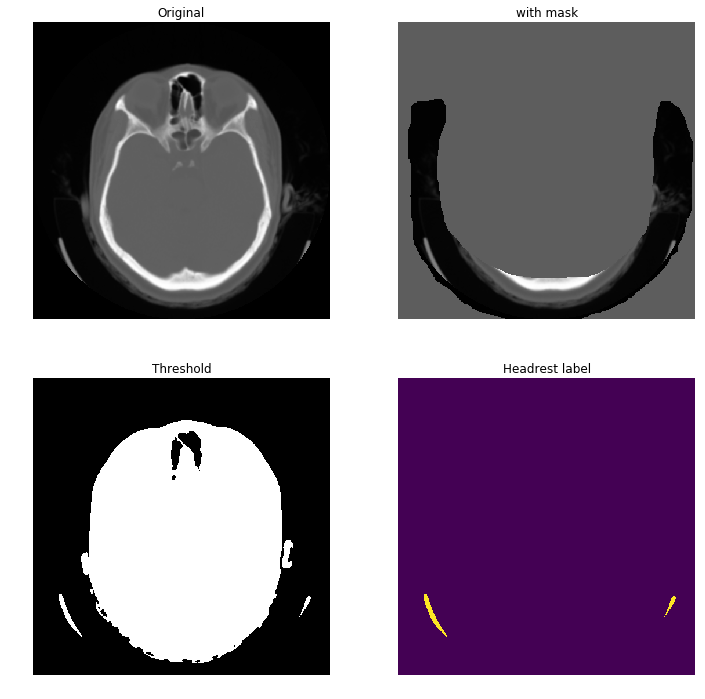

slice 9 :
--------------------------------------------



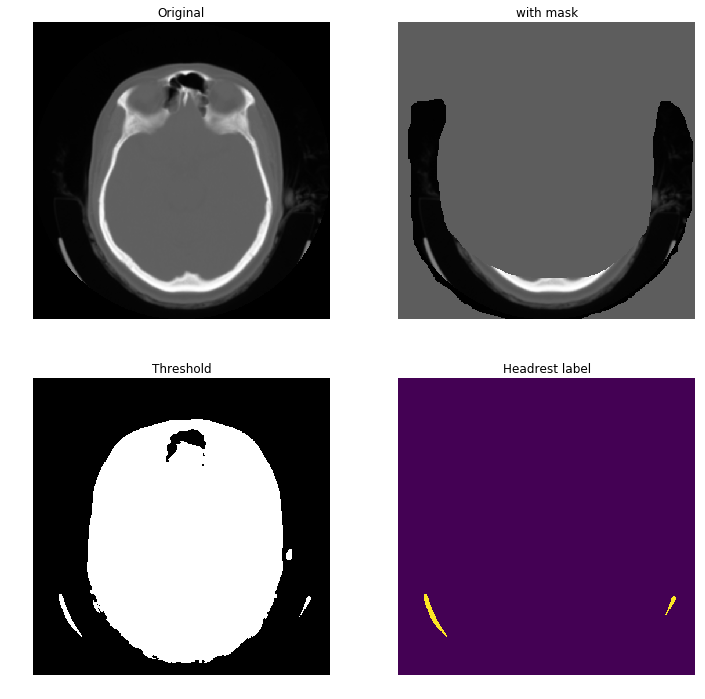

slice 10 :
--------------------------------------------



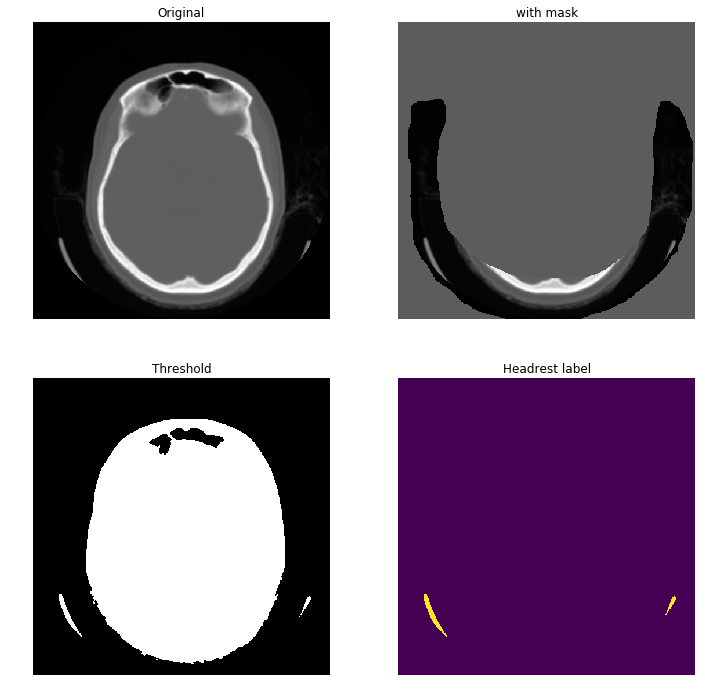

slice 11 :
--------------------------------------------



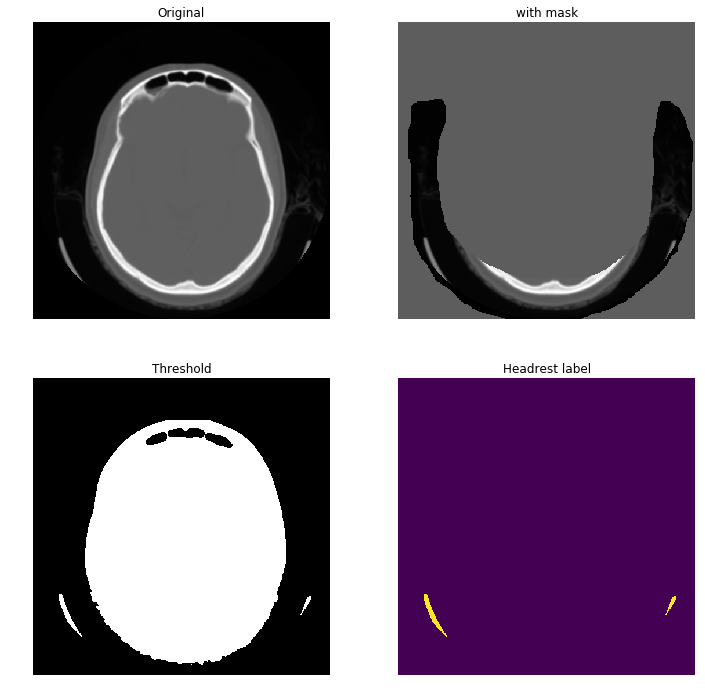

slice 12 :
--------------------------------------------



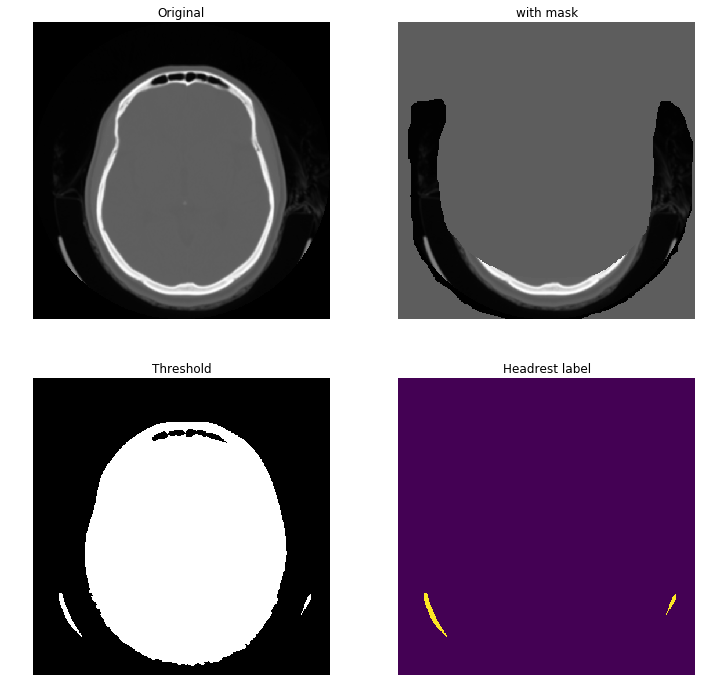

slice 13 :
--------------------------------------------



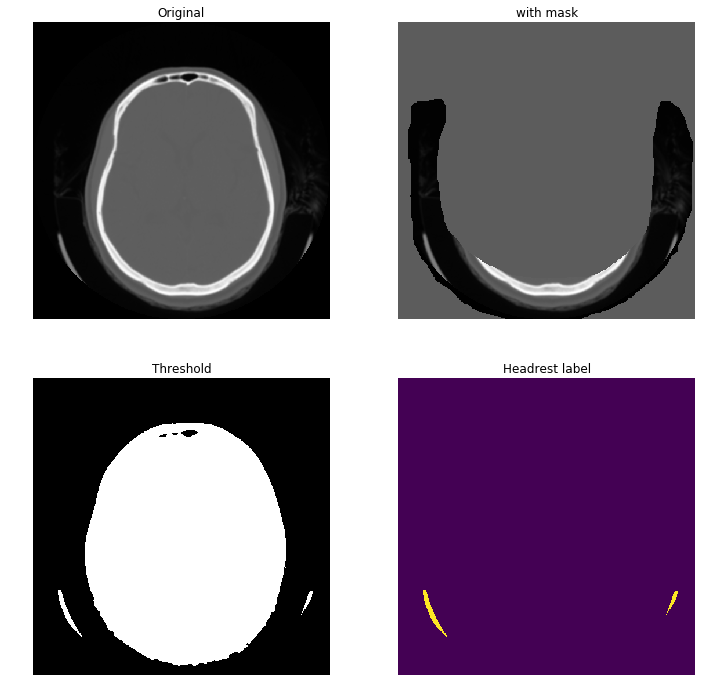

slice 14 :
--------------------------------------------



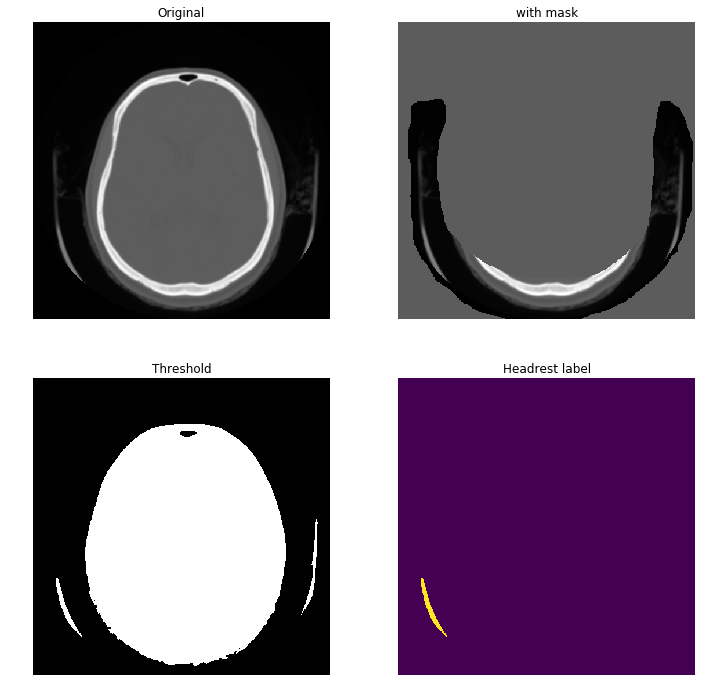

slice 15 :
--------------------------------------------



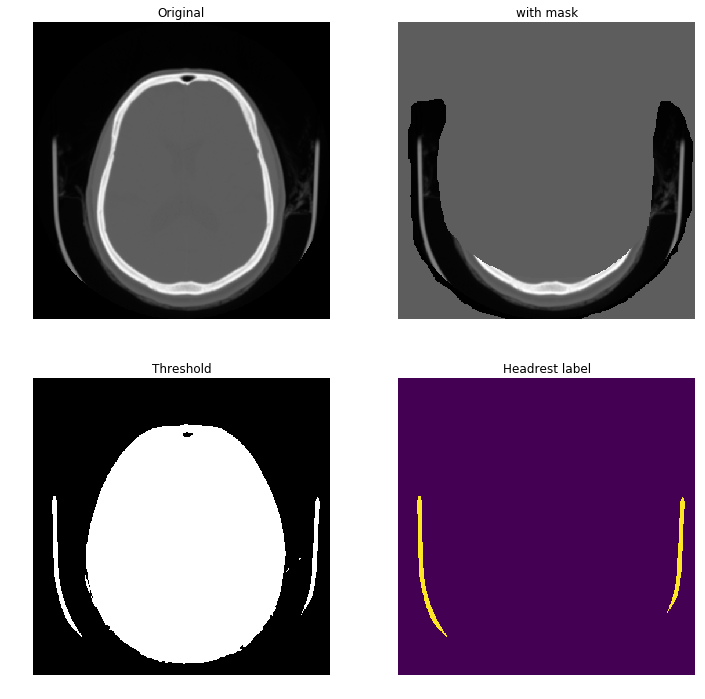

slice 16 :
--------------------------------------------



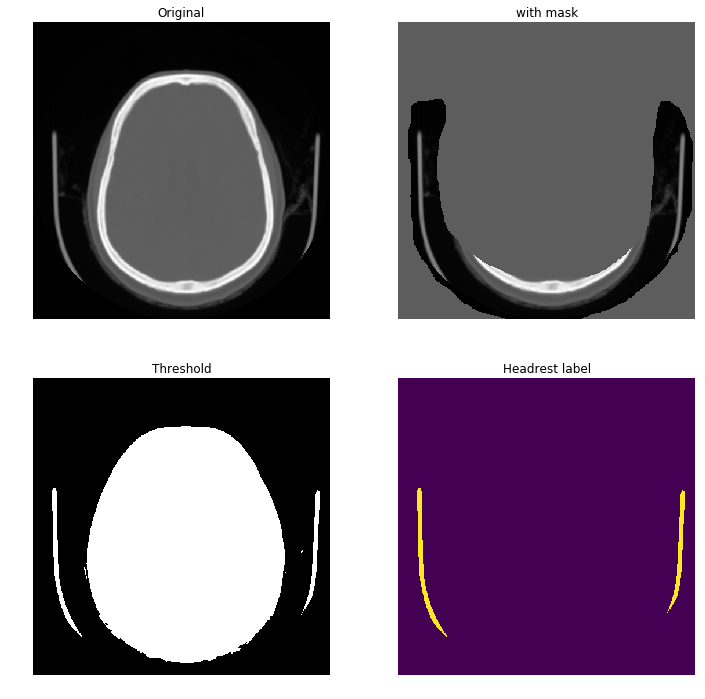

slice 17 :
--------------------------------------------



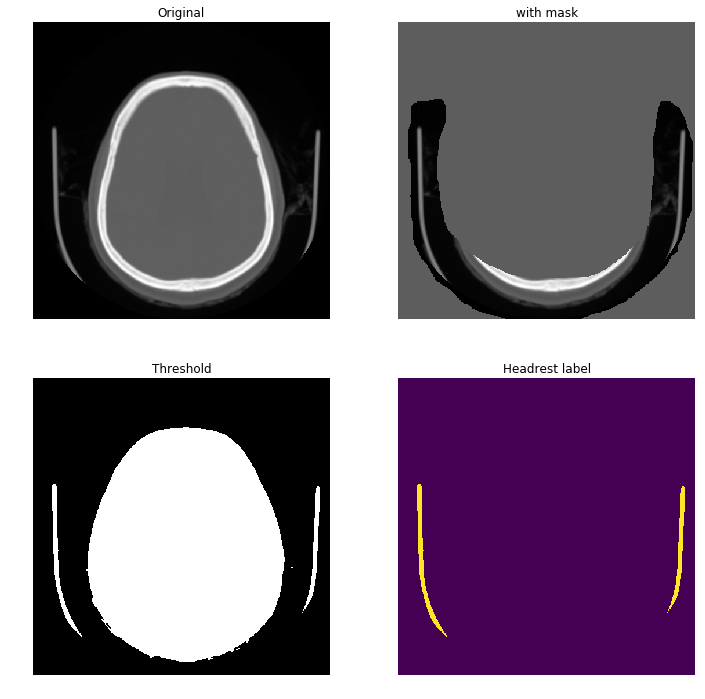

slice 18 :
--------------------------------------------



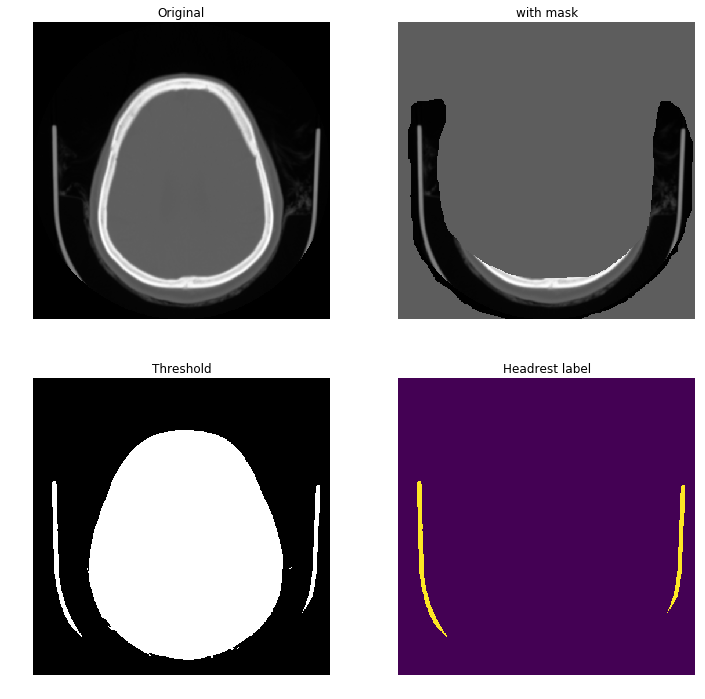

slice 19 :
--------------------------------------------



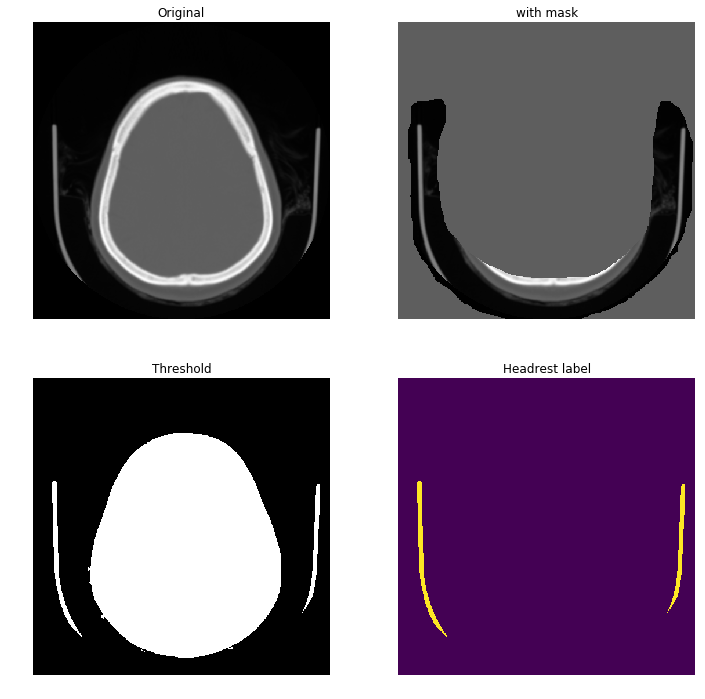

slice 20 :
--------------------------------------------



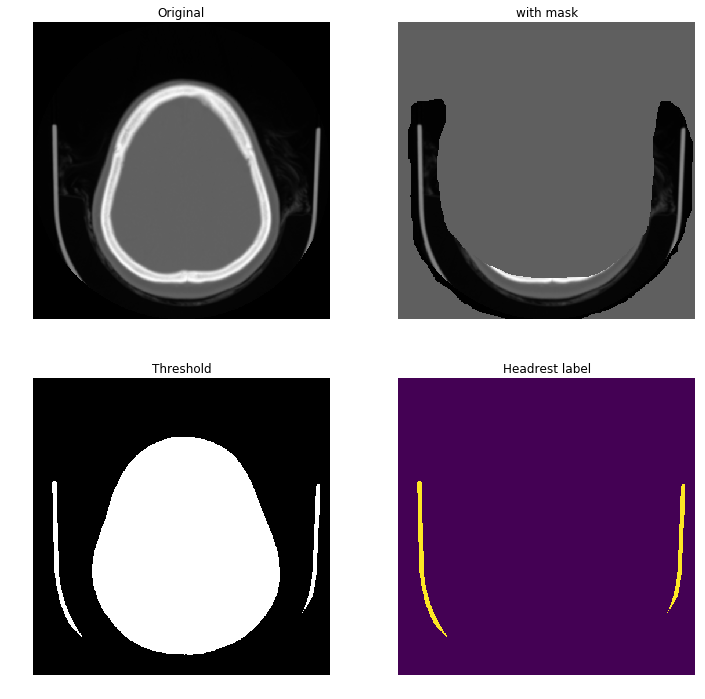

slice 21 :
--------------------------------------------



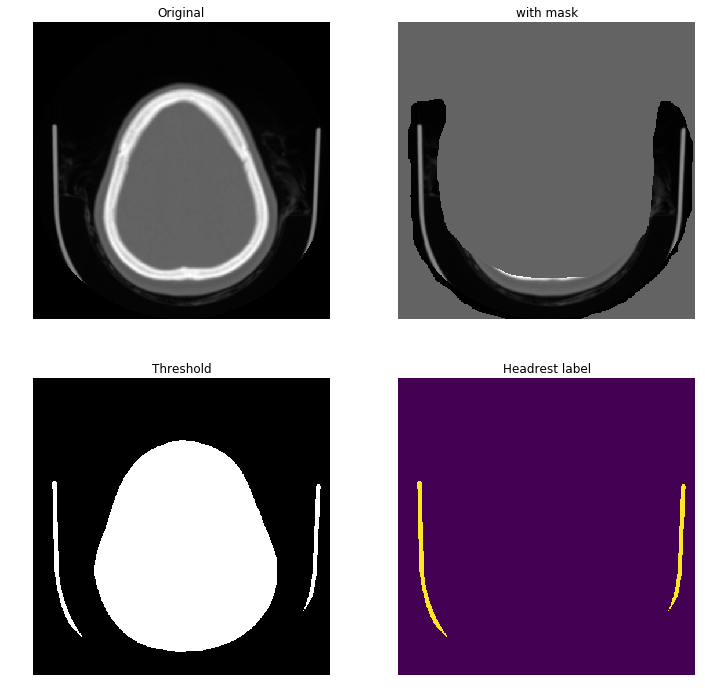

slice 22 :
--------------------------------------------



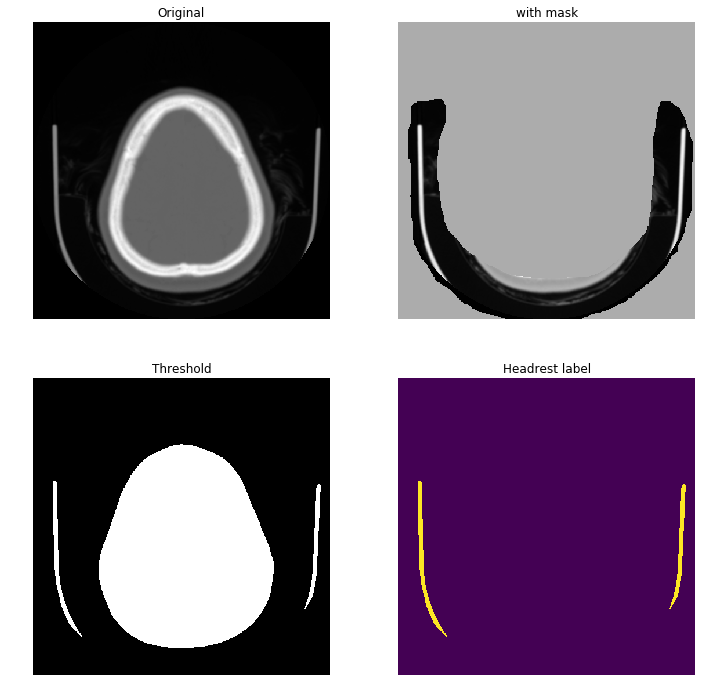

slice 23 :
--------------------------------------------



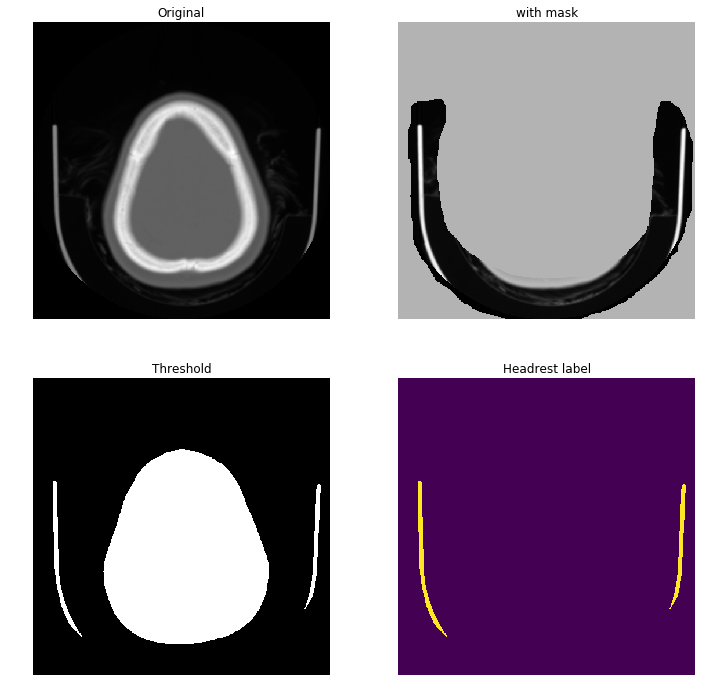

slice 24 :
--------------------------------------------



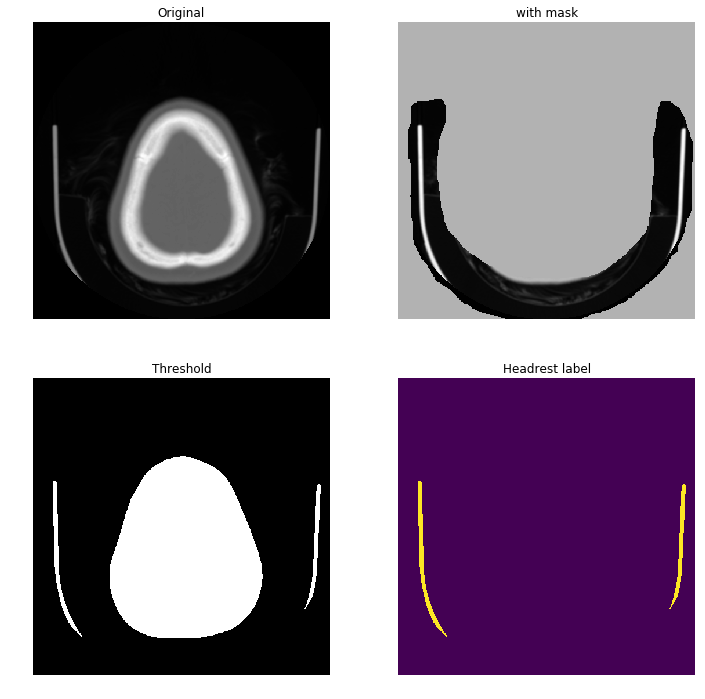

slice 25 :
--------------------------------------------



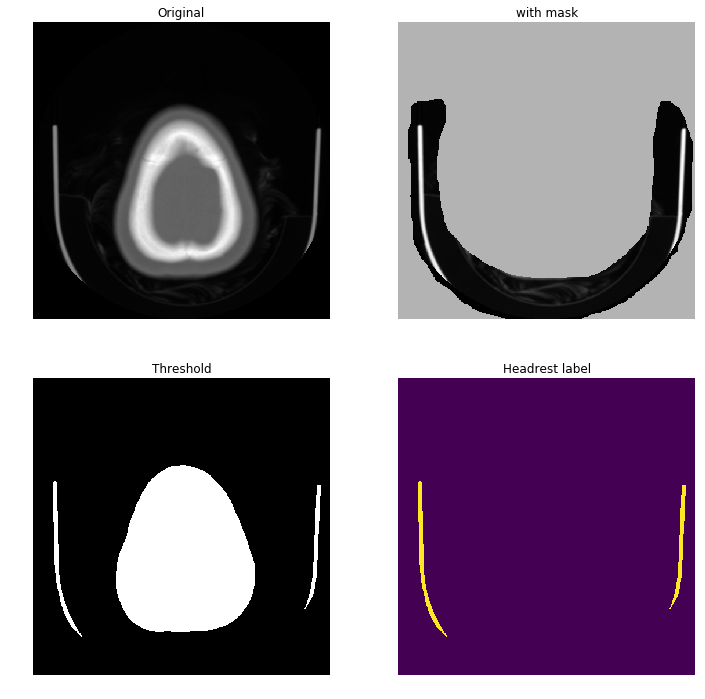

slice 26 :
--------------------------------------------



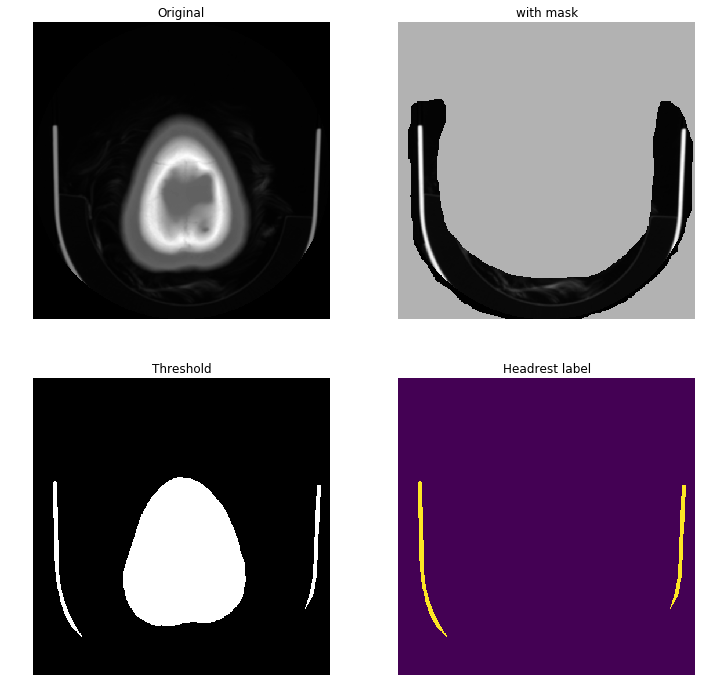

slice 27 :
--------------------------------------------



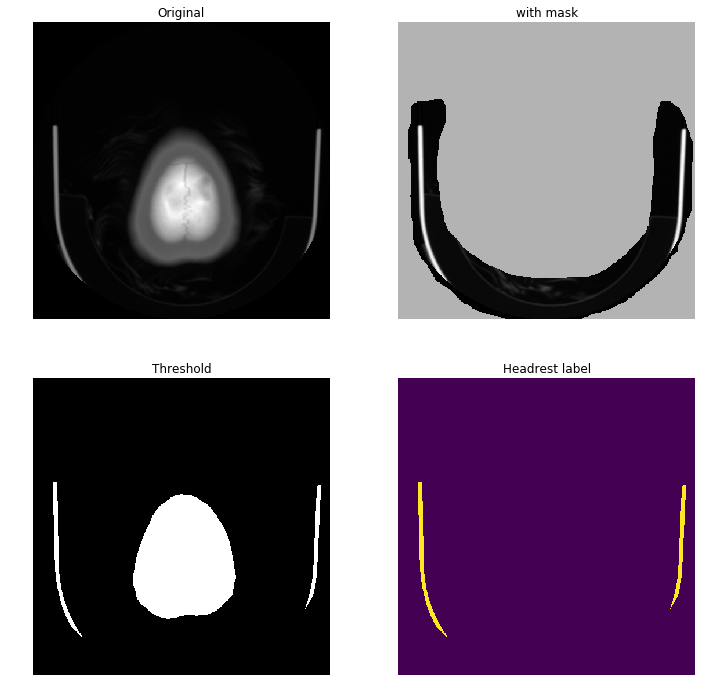

In [67]:
#img = imgs_to_process[1]
i=0
for img in imgs_to_process:
    print("slice %d :" %i)
    headrest_label = headrest_segmented_filter(img, display=True)
    i+=1

______
### **```Creating Data for semantic Segmentation```**

In [ ]:
id = 1000000
imgs_to_process = np.load(output_path+'fullimages_{}.npy'.format(id))
ground_truth = np.zeros_like(imgs_to_process)
for i in range(0,imgs_to_process.shape[0]):
    ground_truth[i] = headrest_segmented_filter(imgs_to_process[i], display=True)

In [ ]:
id = 2
np.save(output_path + "train_images_groundtruth_big_masked_%d.npy" % (id), ground_truth)

In [12]:
id = 2
np.save(output_path + "train_images_input_chest%d.npy" % (id), imgs_to_process)

______

## **```Thank you :)```**
______